In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

Read and process opcode files

In [2]:
def read_opcode_files(base_path):
    data = []
    labels = []
    
    # Walk through all directories
    for apt_folder in os.listdir(base_path):
        apt_path = os.path.join(base_path, apt_folder)
        if os.path.isdir(apt_path):
            # Process each file in the APT folder
            for file_path in glob.glob(os.path.join(apt_path, '*')):
                with open(file_path, 'r') as f:
                    # Split by newline and join with commas
                    opcodes = f.read().strip()
                    opcodes = ', '.join(op.strip() for op in opcodes.split('\n') if op.strip())
                    data.append(opcodes)
                    labels.append(apt_folder)
    
    # Create the DataFrame
    df = pd.DataFrame({'Opcodes': data, 'APT': labels})
    
    # Print the first few rows of the DataFrame
    print("Preview of the DataFrame before n-gram extraction:")
    print(df.head())
    
    # Save to CSV
    output_path = 'opcodes_dataset.csv'
    df.to_csv(output_path, index=False)
    print(f"\nDataset saved to: {output_path}")
    
    return df


def extract_ngram_features(df, n=1):
    if n == 1:
        # Get all unique opcodes
        unique_ngrams = set()
        for opcodes in df['Opcodes']:
            unique_ngrams.update(op.strip() for op in opcodes.split(', '))
        
        # Sort the unique opcodes for consistent column ordering
        unique_ngrams = sorted(unique_ngrams)
        
        # Create a DataFrame with opcode frequencies
        ngram_counts_df = pd.DataFrame(0, index=range(len(df)), columns=unique_ngrams)
        
        # Count frequencies for each sample
        for i, row in df.iterrows():
            opcode_list = [op.strip() for op in row['Opcodes'].split(', ')]
            counts = Counter(opcode_list)
            
            for opcode, count in counts.items():
                ngram_counts_df.at[i, opcode] = count
                
    elif n == 2:
        # Get all unique bigrams from the entire dataset first
        all_bigrams = set()
        for opcodes in df['Opcodes']:
            opcode_list = [op.strip() for op in opcodes.split(', ')]
            bigrams = list(zip(opcode_list[:-1], opcode_list[1:]))
            bigram_strings = [f"{b[0]}_{b[1]}" for b in bigrams]
            all_bigrams.update(bigram_strings)
        
        # Sort the unique bigrams for consistent column ordering
        unique_bigrams = sorted(all_bigrams)
        
        # Create a DataFrame with bigram frequencies
        ngram_counts_df = pd.DataFrame(0, index=range(len(df)), columns=unique_bigrams)
        
        # Count frequencies for each sample
        for i, row in df.iterrows():
            opcode_list = [op.strip() for op in row['Opcodes'].split(', ')]
            bigrams = list(zip(opcode_list[:-1], opcode_list[1:]))
            bigram_strings = [f"{b[0]}_{b[1]}" for b in bigrams]
            counts = Counter(bigram_strings)
            
            for bigram, count in counts.items():
                ngram_counts_df.at[i, bigram] = count
    
    return ngram_counts_df.values, ngram_counts_df.columns.tolist()

Read the data
Extract features
Combine features
Encode labels
Train/test split

In [3]:
base_path = '/Users/jeffreyjeyachandren/Desktop/opscode_ml/opcodes'  # Adjust this to your opscode folder path
df = read_opcode_files(base_path)

# Get features
X_1gram, cols_1gram = extract_ngram_features(df, n=1)
X_2gram, cols_2gram = extract_ngram_features(df, n=2)

# Combine features
X = np.concatenate([X_1gram, X_2gram], axis=1)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['APT'])

# Print shape information
print(f"Shape of 1-gram features: {X_1gram.shape}")
print(f"Shape of 2-gram features: {X_2gram.shape}")
print(f"Shape of combined features: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")

# Split and continue with classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Preview of the DataFrame before n-gram extraction:
                                             Opcodes            APT
0  JMP, JMP, JMP, JMP, JMP, JMP, JMP, JMP, POP, P...        Evilnum
1  PUSH, MOV, MOV, CALL, PUSH, PUSH, PUSH, PUSH, ...  APT19_opcodes
2  MOV, PUSH, MOV, CALL, TEST, PUSH, CALL, ADD, M...  APT19_opcodes
3  PUSH, PUSH, PUSH, MOV, CMP, JE, CMP, JNE, PUSH...  APT19_opcodes
4  PUSH, PUSH, PUSH, MOV, CMP, JE, CMP, JNE, PUSH...  APT19_opcodes

Dataset saved to: opcodes_dataset.csv
Shape of 1-gram features: (215, 520)
Shape of 2-gram features: (215, 5653)
Shape of combined features: (215, 6173)
Number of classes: 32


In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
classifiers = {
    'SVM': SVC(kernel='rbf'),
    'KNN-3': KNeighborsClassifier(n_neighbors=3),
    'KNN-5': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier()
}

# Train and evaluate classifiers
results = {}
for name, clf in classifiers.items():
    # Train
    clf.fit(X_train, y_train)
    
    # Predict
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
        # Get unique classes present in the test set
    unique_classes = np.unique(y_test)
    target_names = le.inverse_transform(unique_classes)
    
    # Generate classification report
    report = classification_report(y_test, y_pred, 
                                 labels=unique_classes,
                                 target_names=target_names)
    
    results[name] = {
        'accuracy': accuracy,
        'report': report
    }

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Results

In [5]:
# Print results
for name, result in results.items():
    print(f"\n{name} Results:")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("\nClassification Report:")
    print(result['report'])


SVM Results:
Accuracy: 0.3023

Classification Report:
                 precision    recall  f1-score   support

  APT12_opcodes       0.00      0.00      0.00         1
  APT17_opcodes       0.00      0.00      0.00         1
   APT1_opcodes       0.00      0.00      0.00         4
          APT28       0.00      0.00      0.00         3
          APT29       0.29      0.33      0.31         6
  APT30_opcodes       0.00      0.00      0.00         3
BlueMockingbird       0.00      0.00      0.00         1
      Elderwood       0.00      0.00      0.00         1
           FIN7       0.00      0.00      0.00         1
        Gallium       0.00      0.00      0.00         1
      Gamaredon       0.00      0.00      0.00         1
       Ke3chang       0.00      0.00      0.00         2
       MenuPass       0.00      0.00      0.00         1
         Moafee       0.31      1.00      0.48        11
       Sandworm       0.00      0.00      0.00         1
          Turla       0.00      

Evaluate the classifiers when using 1-gram and 2-gram features

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

SVM Results (before balancing data):
Accuracy: 0.3256

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3
           5       0.40      0.33      0.36         6
           6       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         1
          22       0.31      1.00      0.48        11
          24       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         5

  

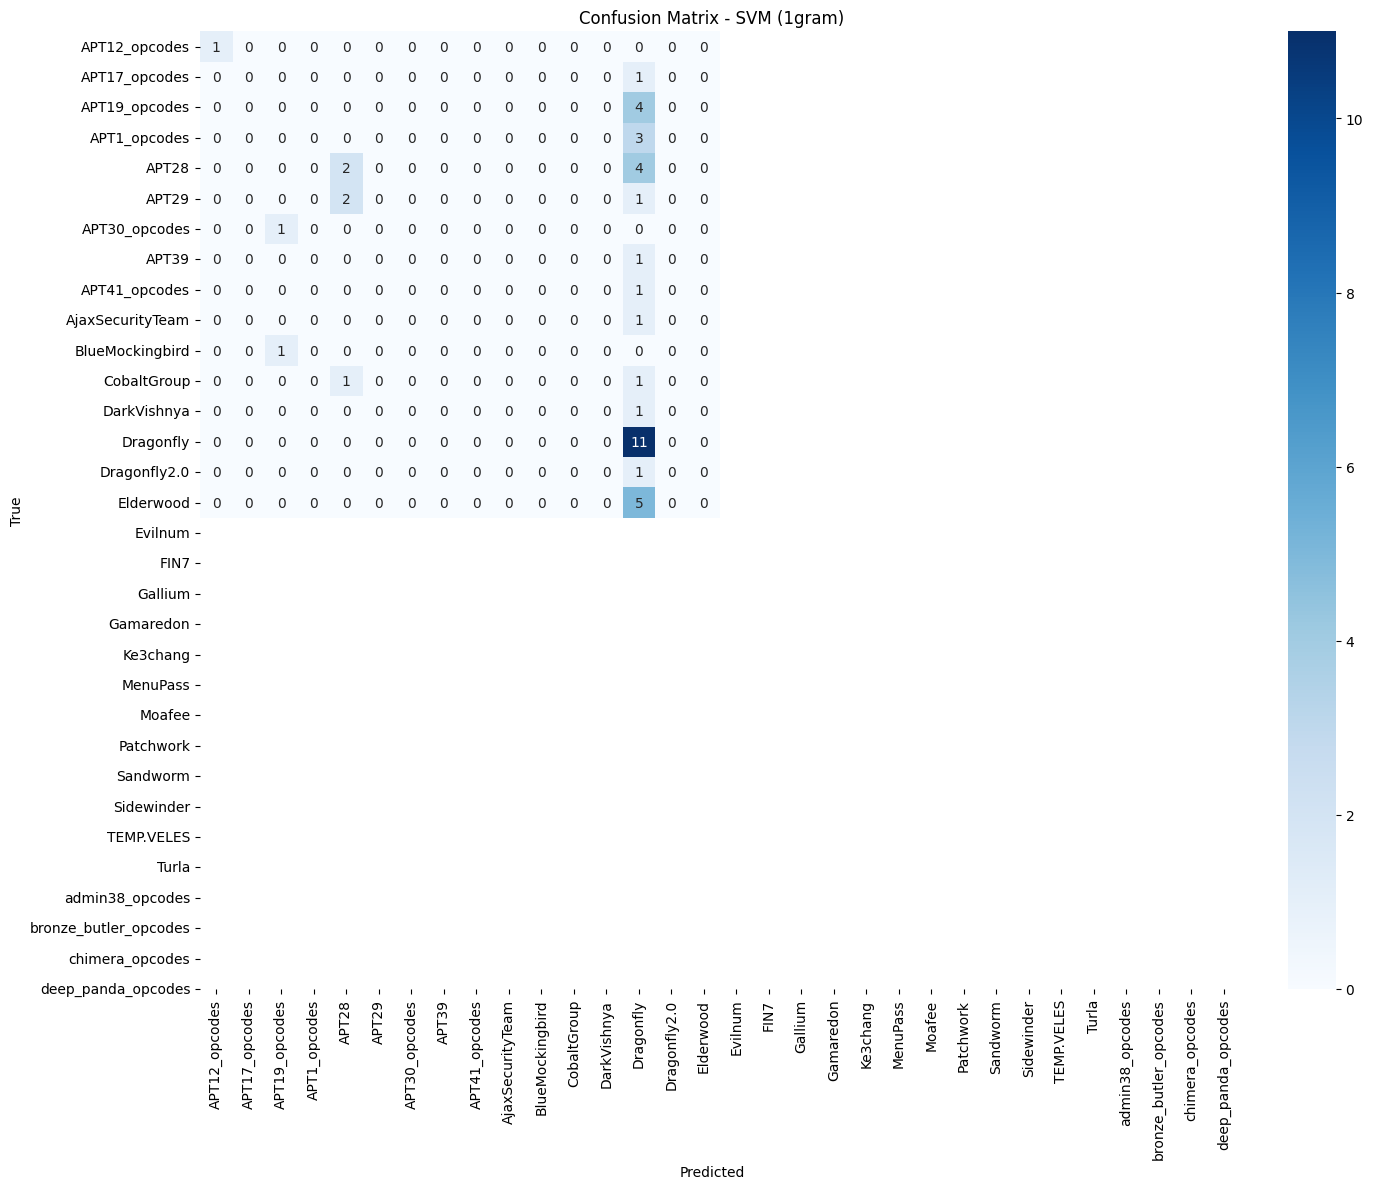

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

KNN-3 Results (before balancing data):
Accuracy: 0.3721

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3
           5       0.28      0.83      0.42         6
           6       0.60      1.00      0.75         3
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         1
          22       0.78      0.64      0.70        11
 

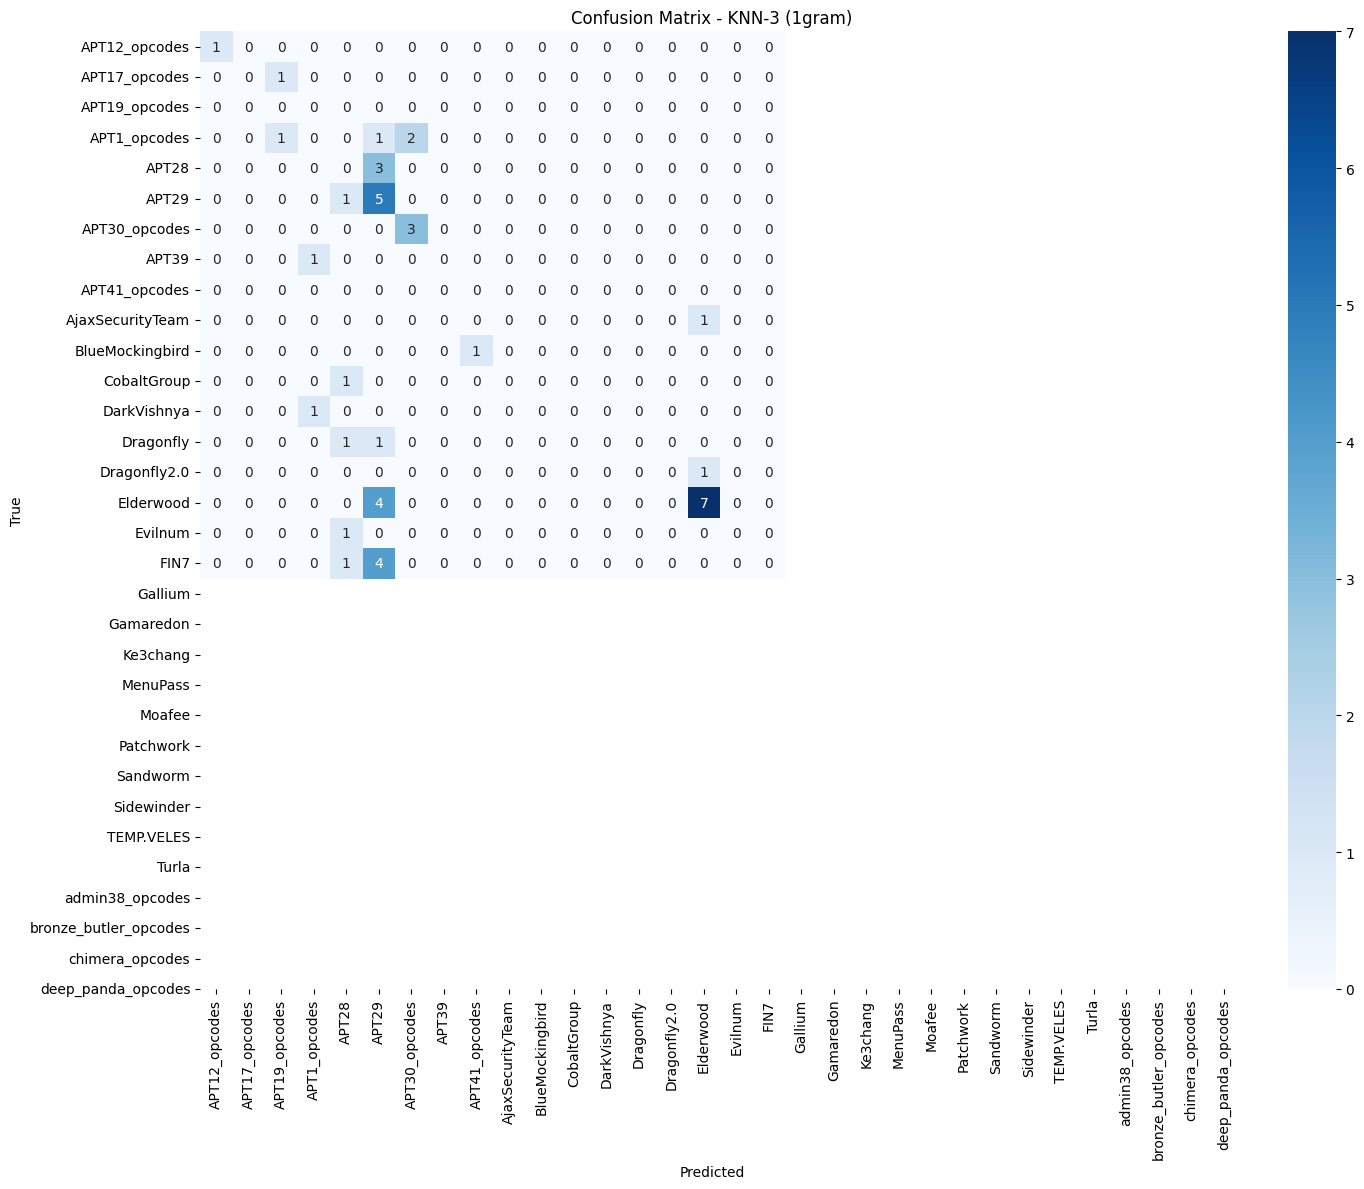

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

KNN-5 Results (before balancing data):
Accuracy: 0.2558

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.25      0.25      0.25         4
           4       0.00      0.00      0.00         3
           5       0.21      0.67      0.32         6
           6       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         1
          22       0.83      0.45      0.59        11
          24       0.00      0.00      0.00         1
 

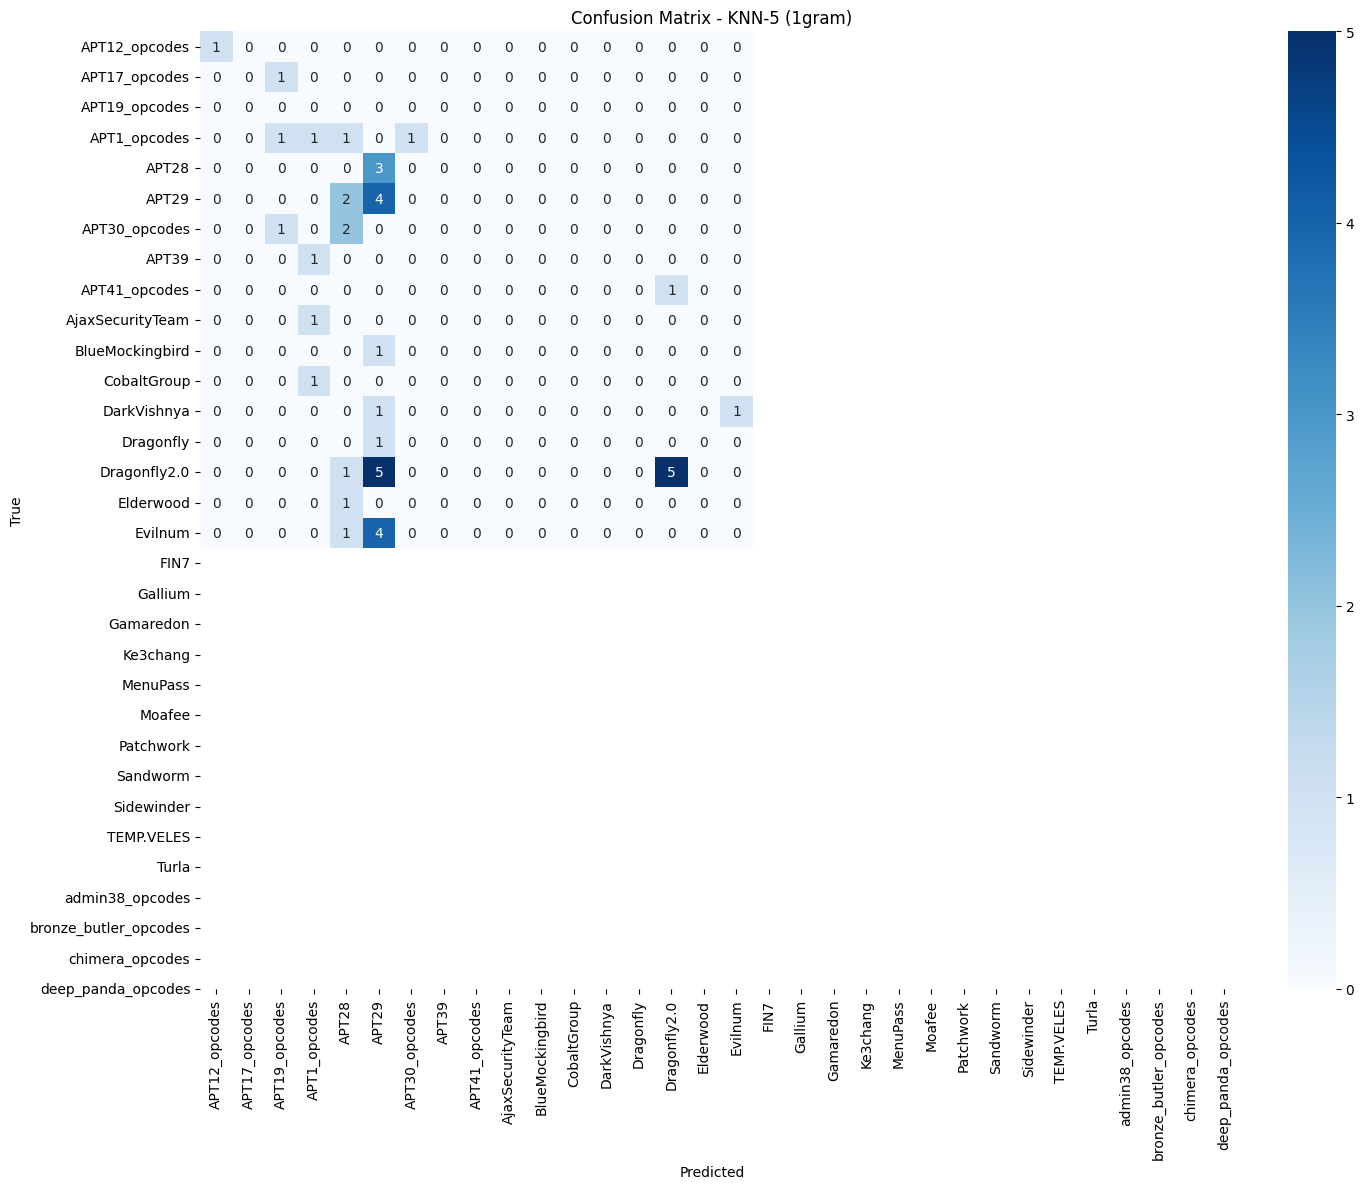

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Decision Tree Results (before balancing data):
Accuracy: 0.4884

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       1.00      0.25      0.40         4
           4       0.00      0.00      0.00         3
           5       0.71      0.83      0.77         6
           6       0.67      0.67      0.67         3
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.50      1.00      0.67         1
          19       0.00      0.00      0.00         1
          20       1.00      0.50      0.67    

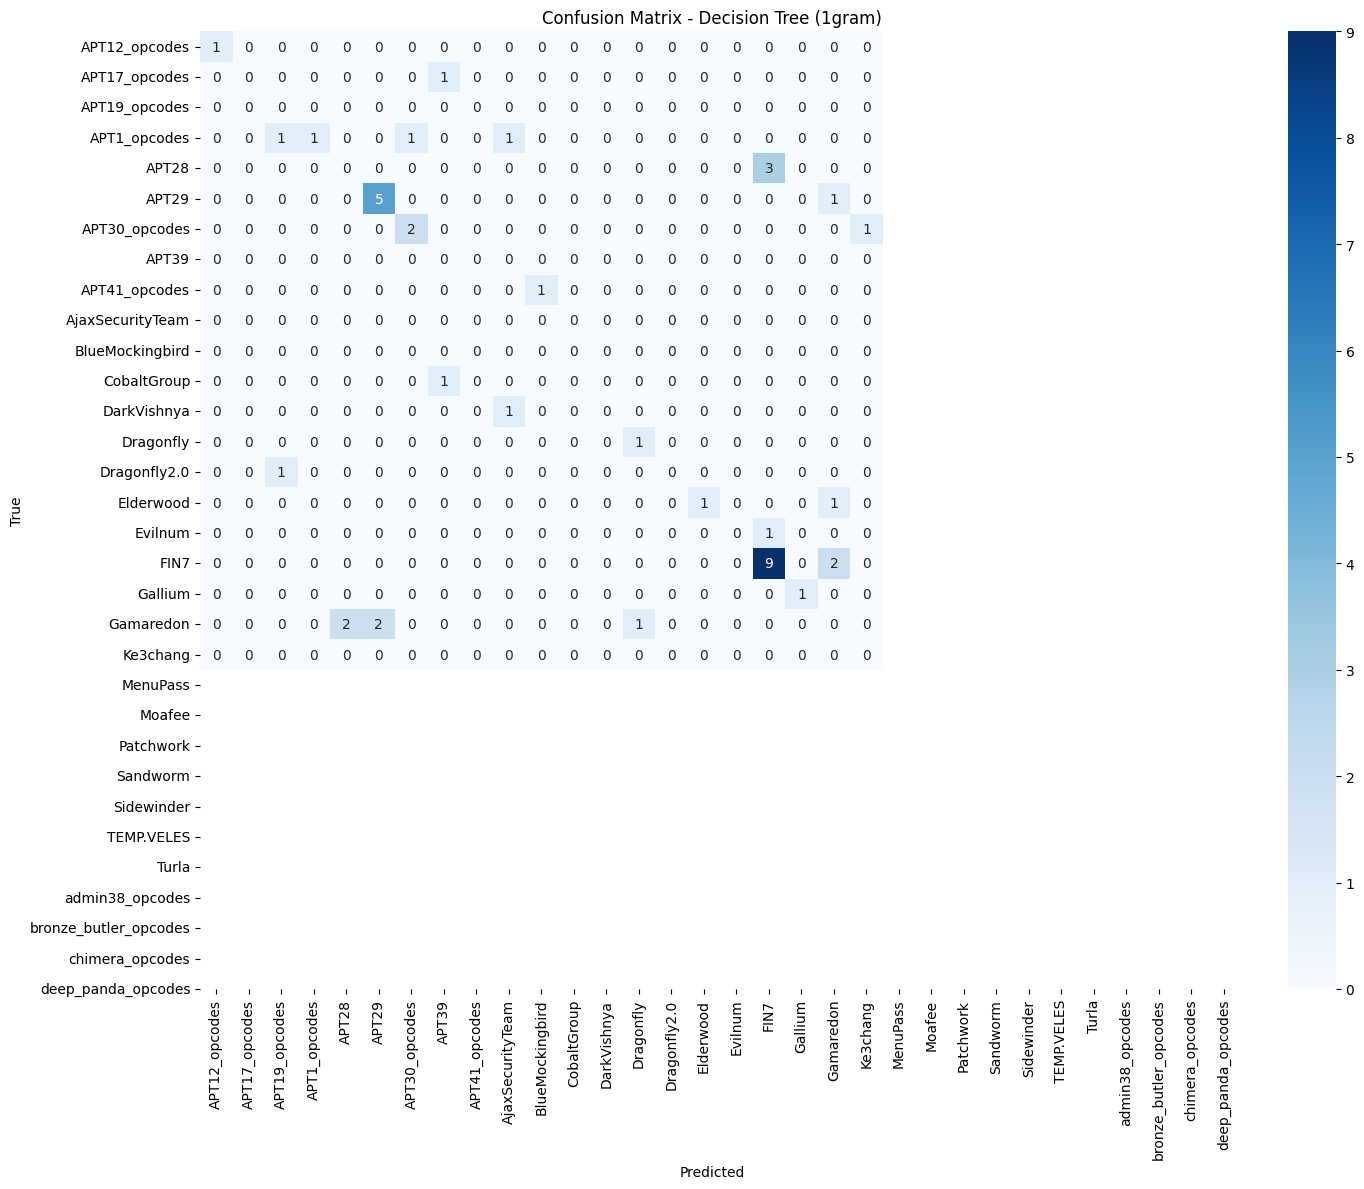

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

SVM Results (before balancing data):
Accuracy: 0.3488

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3
           5       0.67      0.33      0.44         6
           6       1.00      0.67      0.80         3
          10       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         1
          22       0.30      1.00      0.46        11
          24       0.00      0.00      0.00         1
   

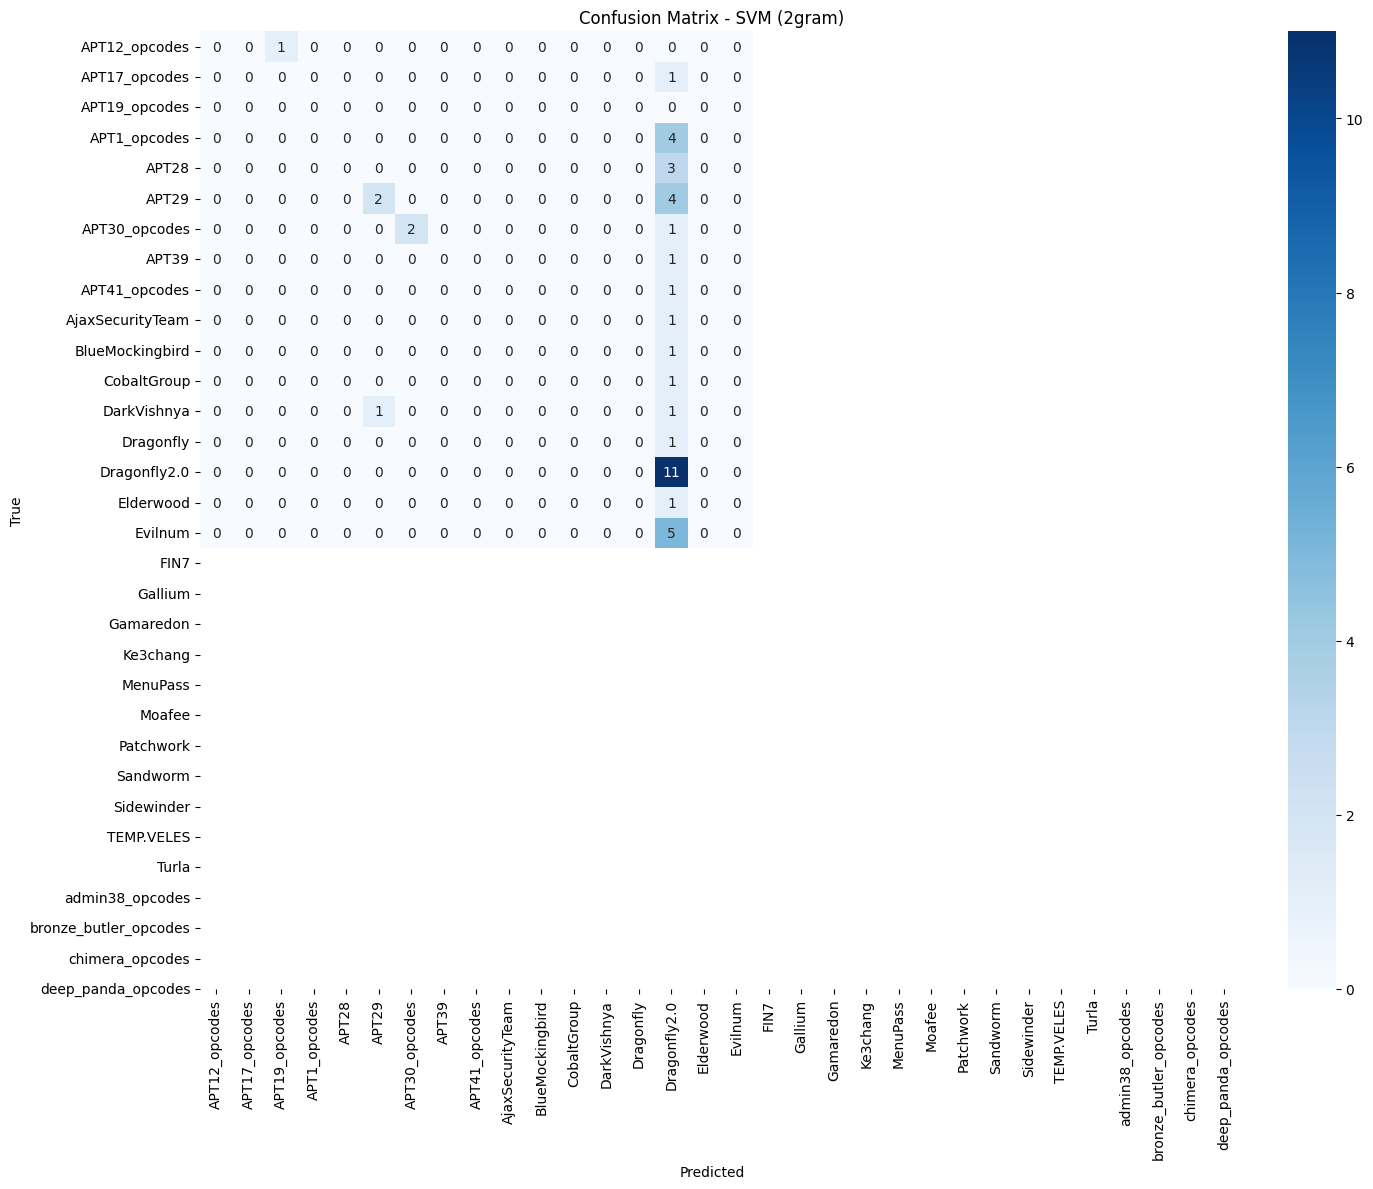

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

KNN-3 Results (before balancing data):
Accuracy: 0.4186

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.33      0.25      0.29         4
           4       0.27      1.00      0.43         3
           5       0.33      0.67      0.44         6
           6       0.67      0.67      0.67         3
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         1
          22       0.70      0.64      0.67        11
 

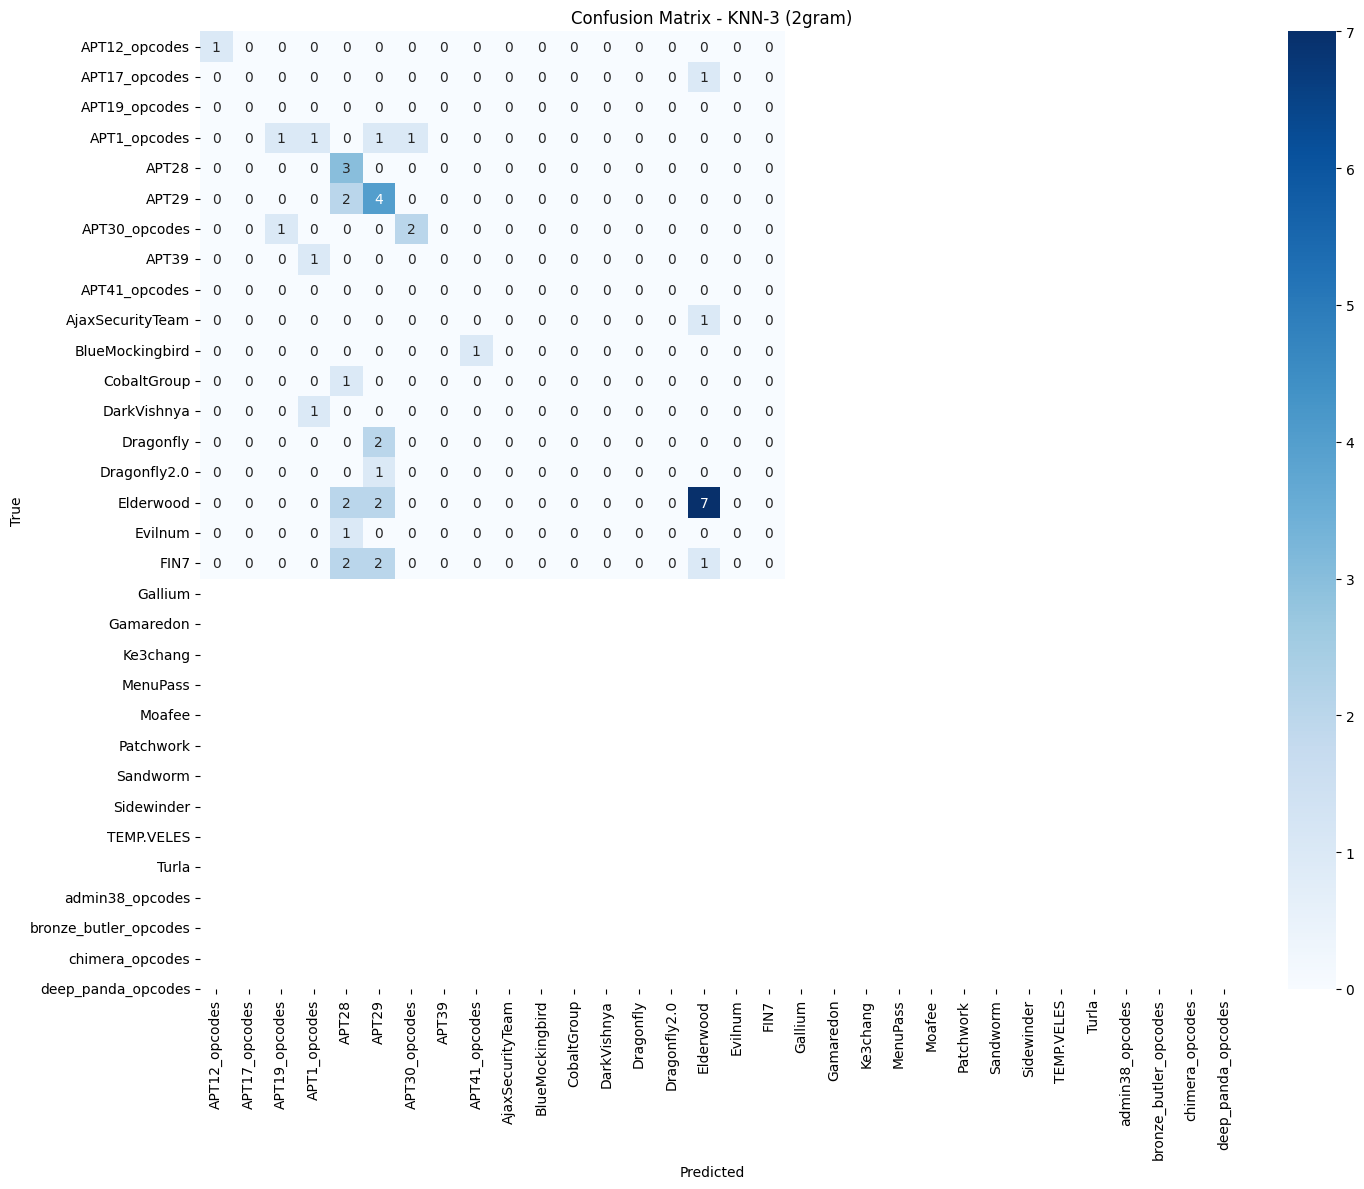

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

KNN-5 Results (before balancing data):
Accuracy: 0.2791

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.50      0.25      0.33         4
           4       0.00      0.00      0.00         3
           5       0.26      0.83      0.40         6
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         1
          22       0.56      0.45      0.50        11
 

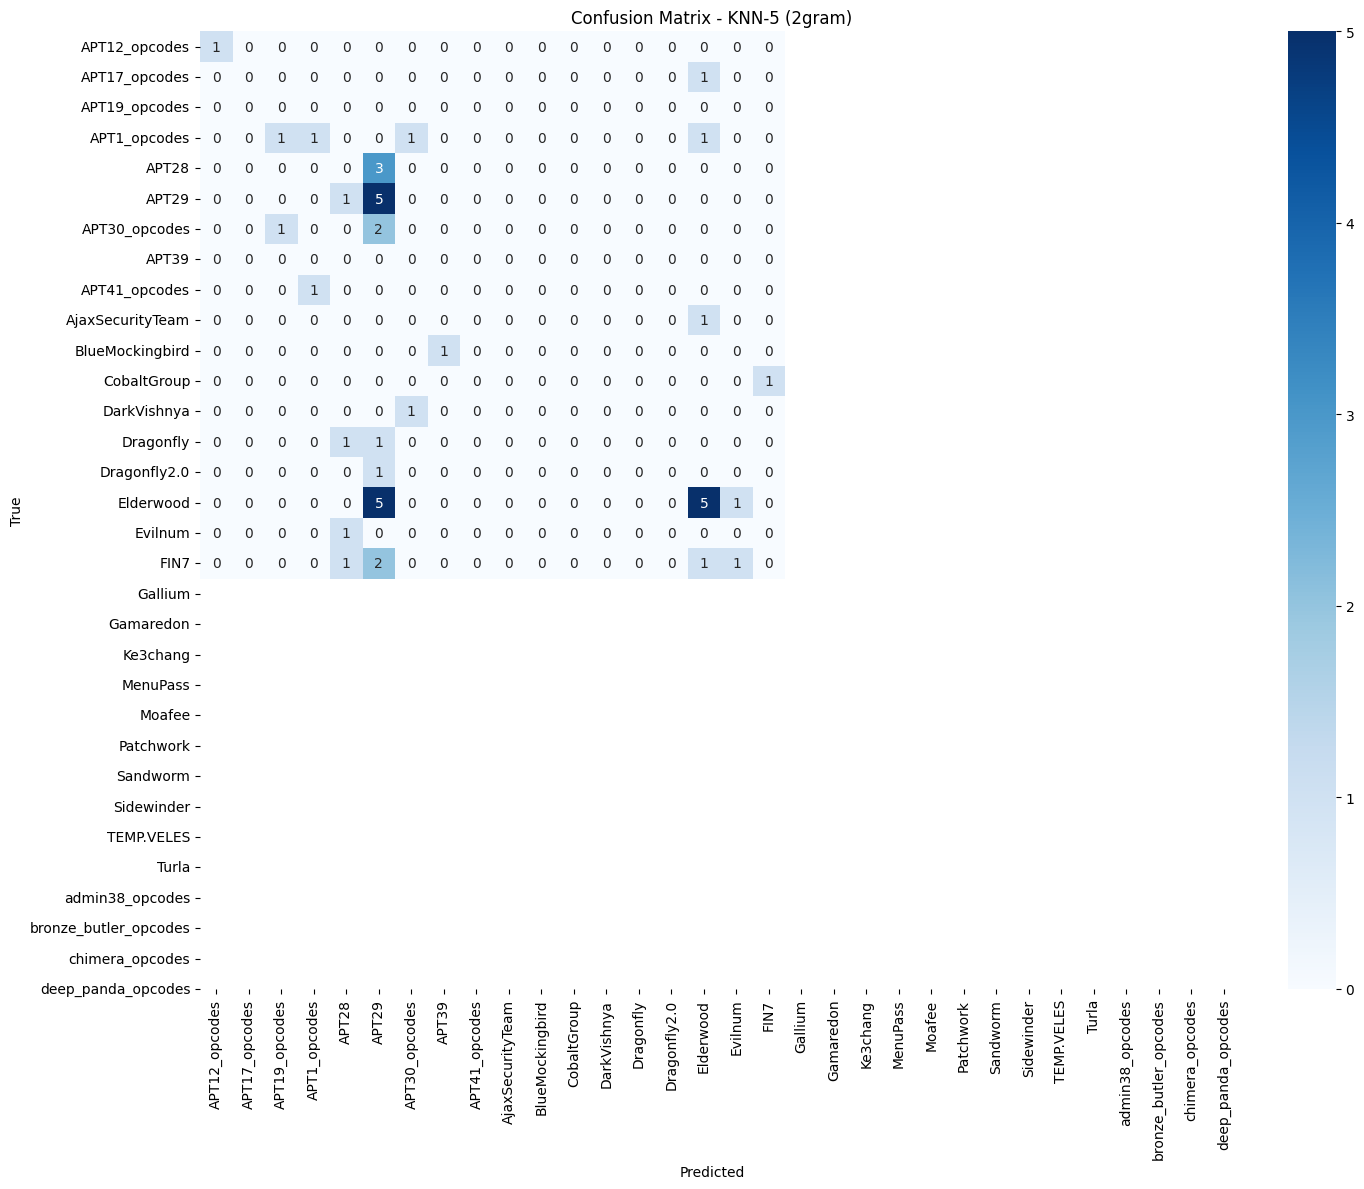

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Decision Tree Results (before balancing data):
Accuracy: 0.4651

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3
           5       0.38      0.83      0.53         6
           6       0.75      1.00      0.86         3
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         1
          17       1.00      1.00      1.00         1
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00    

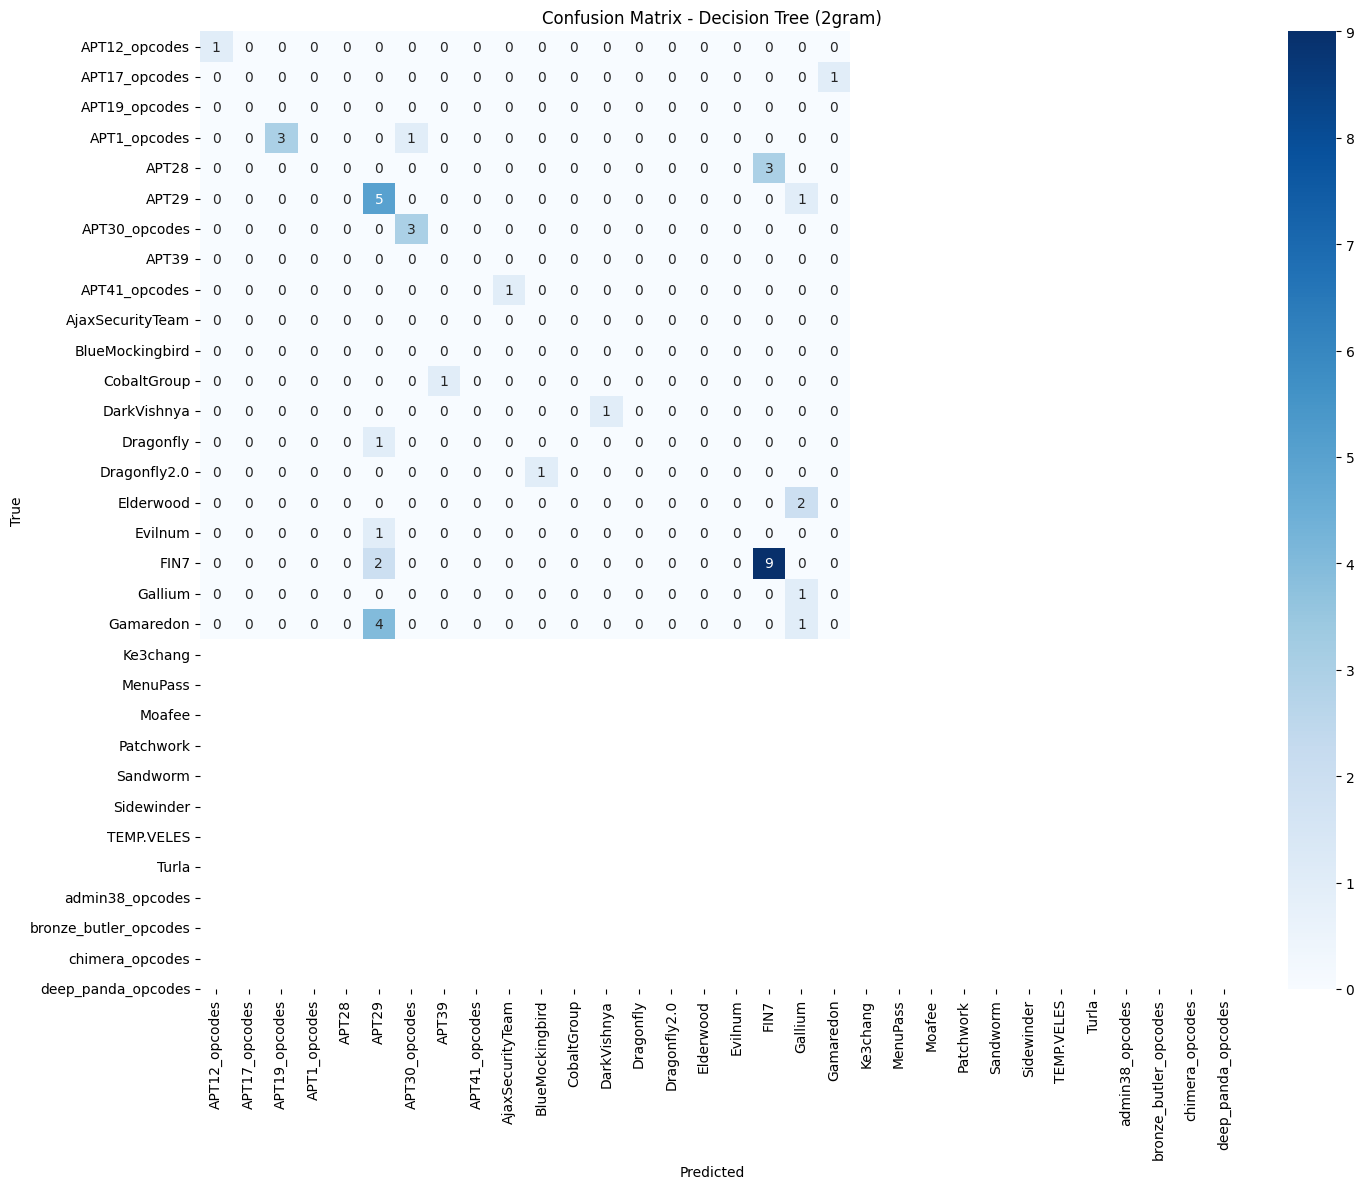

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

SVM Results (before balancing data):
Accuracy: 0.3023

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3
           5       0.29      0.33      0.31         6
           6       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         1
          22       0.31      1.00      0.48        11
          24       0.00      0.00      0.00         1
   

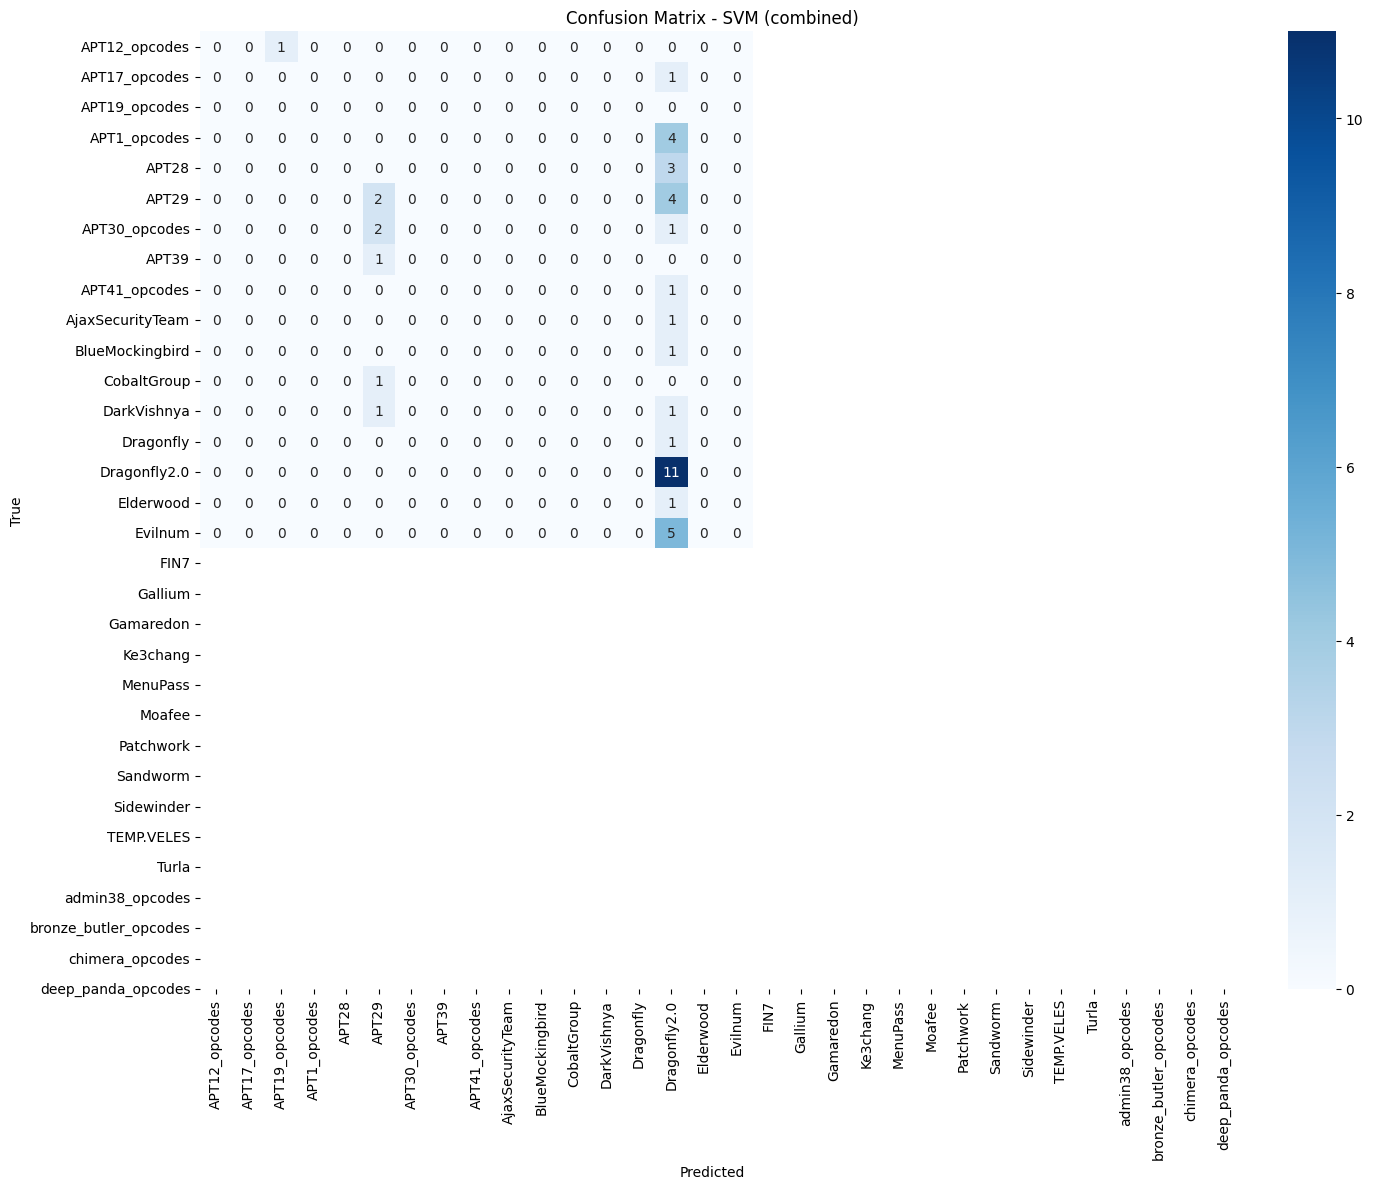

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

KNN-3 Results (before balancing data):
Accuracy: 0.4651

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.33      0.25      0.29         4
           4       0.27      1.00      0.43         3
           5       0.42      0.83      0.56         6
           6       0.75      1.00      0.86         3
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         1
          22       0.78      0.64      0.70        11
 

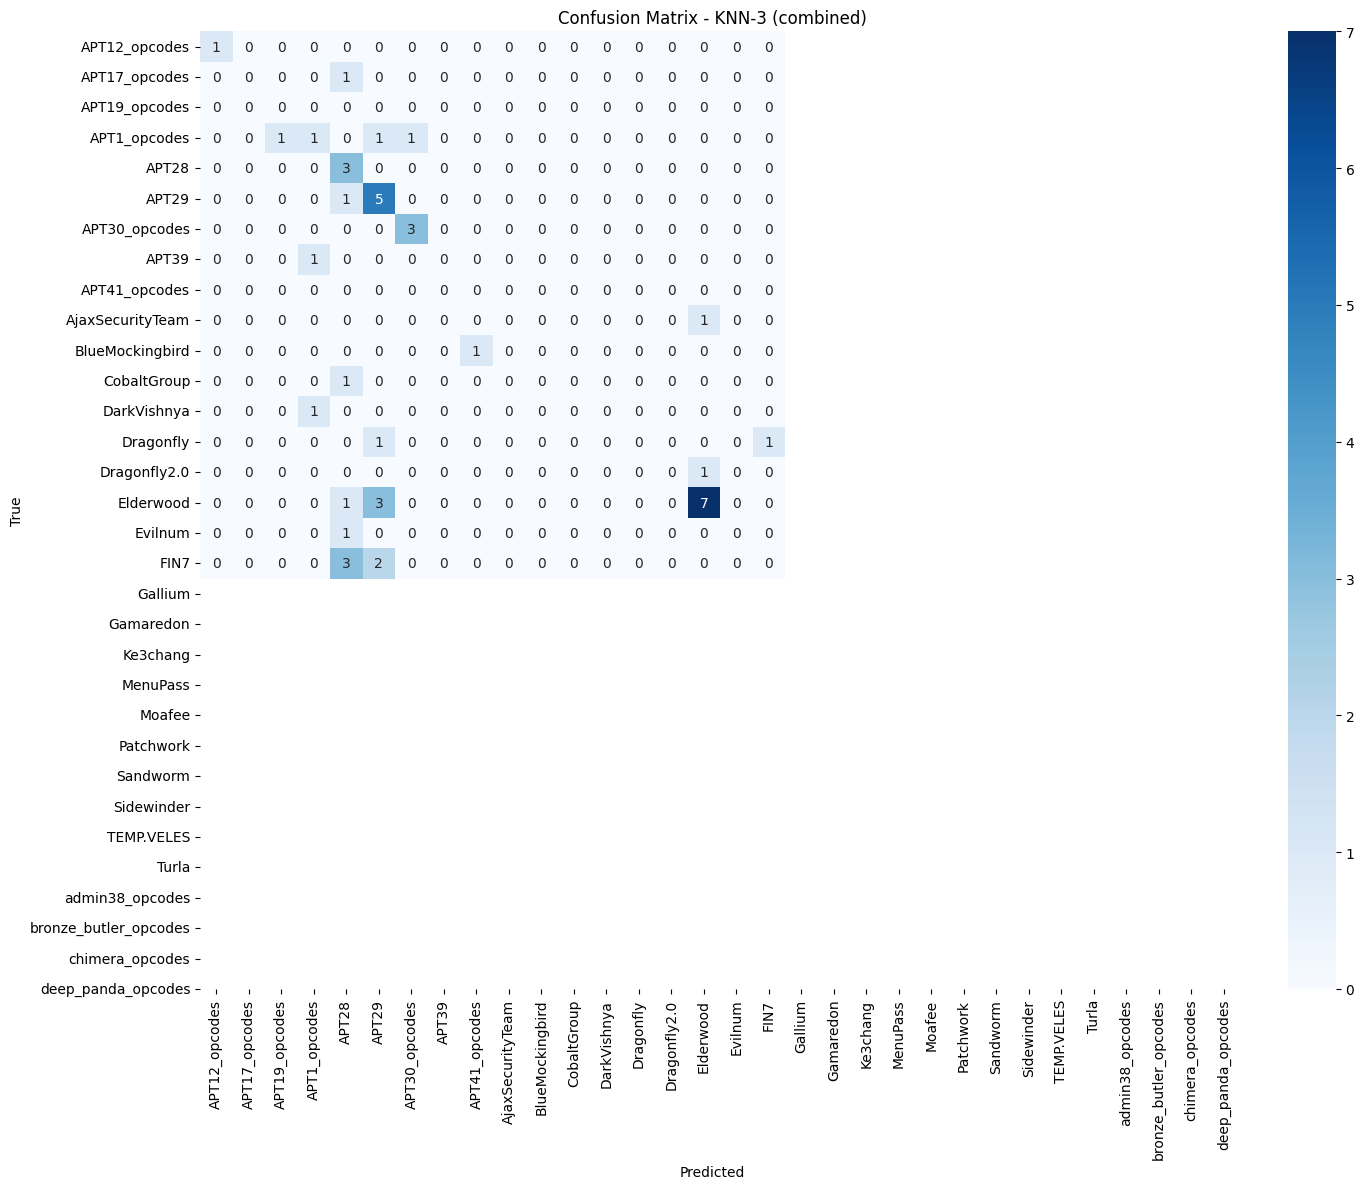

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

KNN-5 Results (before balancing data):
Accuracy: 0.2791

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.25      0.25      0.25         4
           4       0.00      0.00      0.00         3
           5       0.21      0.83      0.33         6
           6       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         1
          22       0.62      0.45      0.53        11
          24       0.00      0.00      0.00         1
 

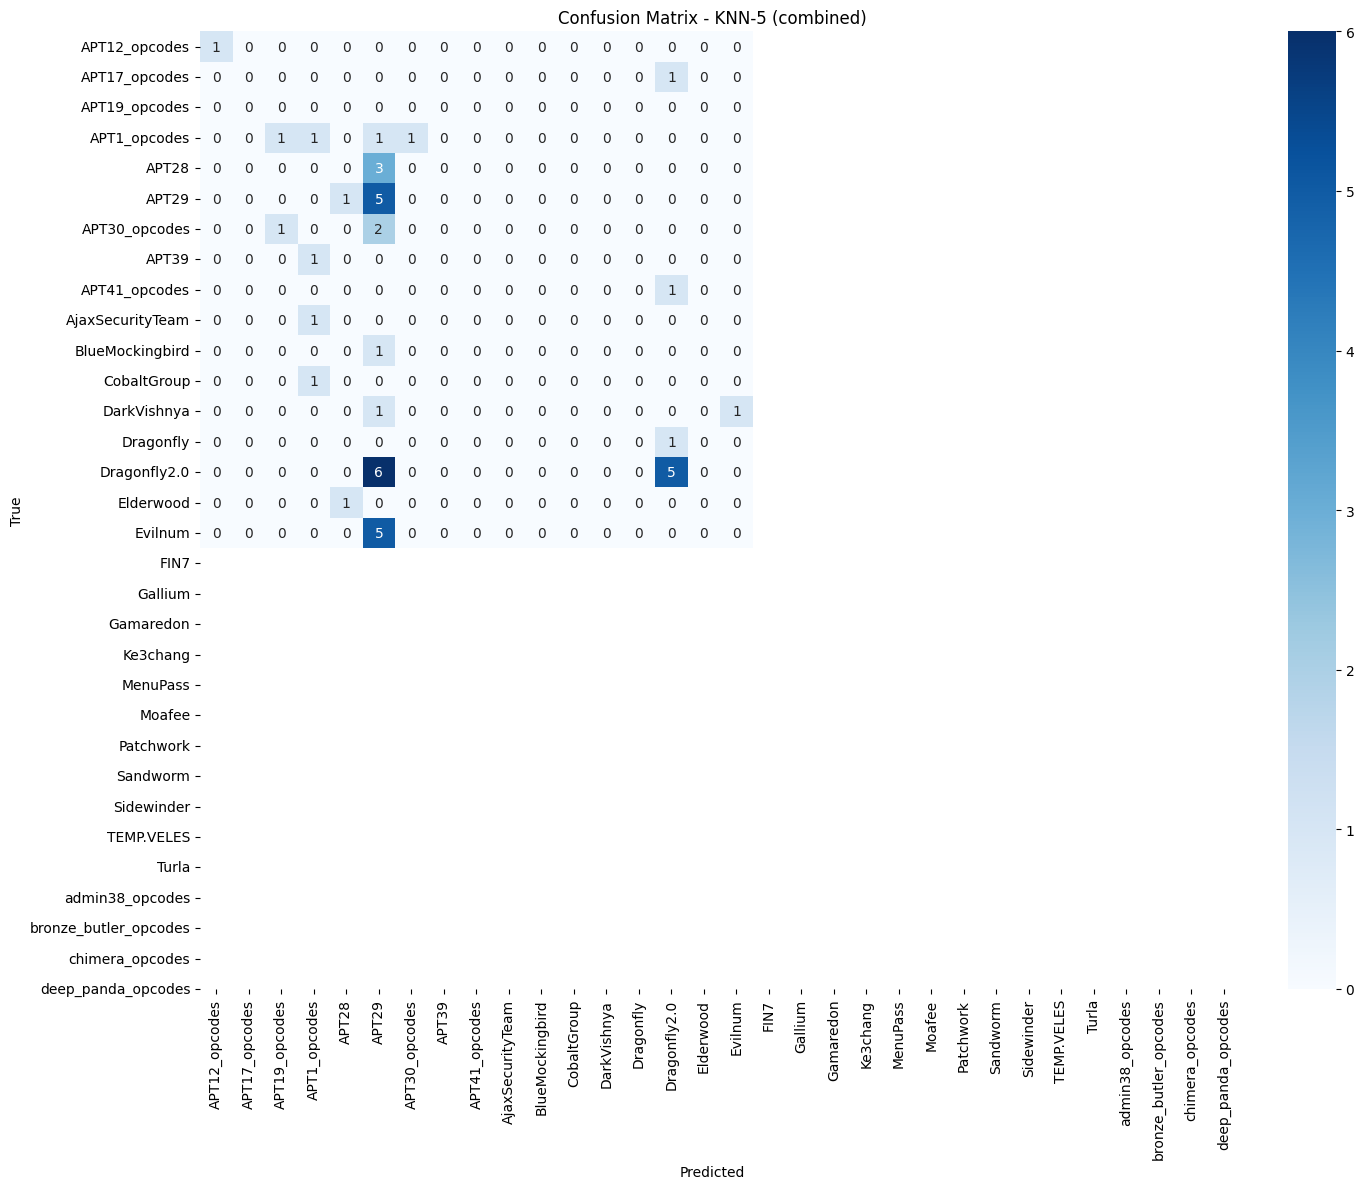

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Decision Tree Results (before balancing data):
Accuracy: 0.4186

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3
           5       0.44      0.67      0.53         6
           6       0.75      1.00      0.86         3
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00    

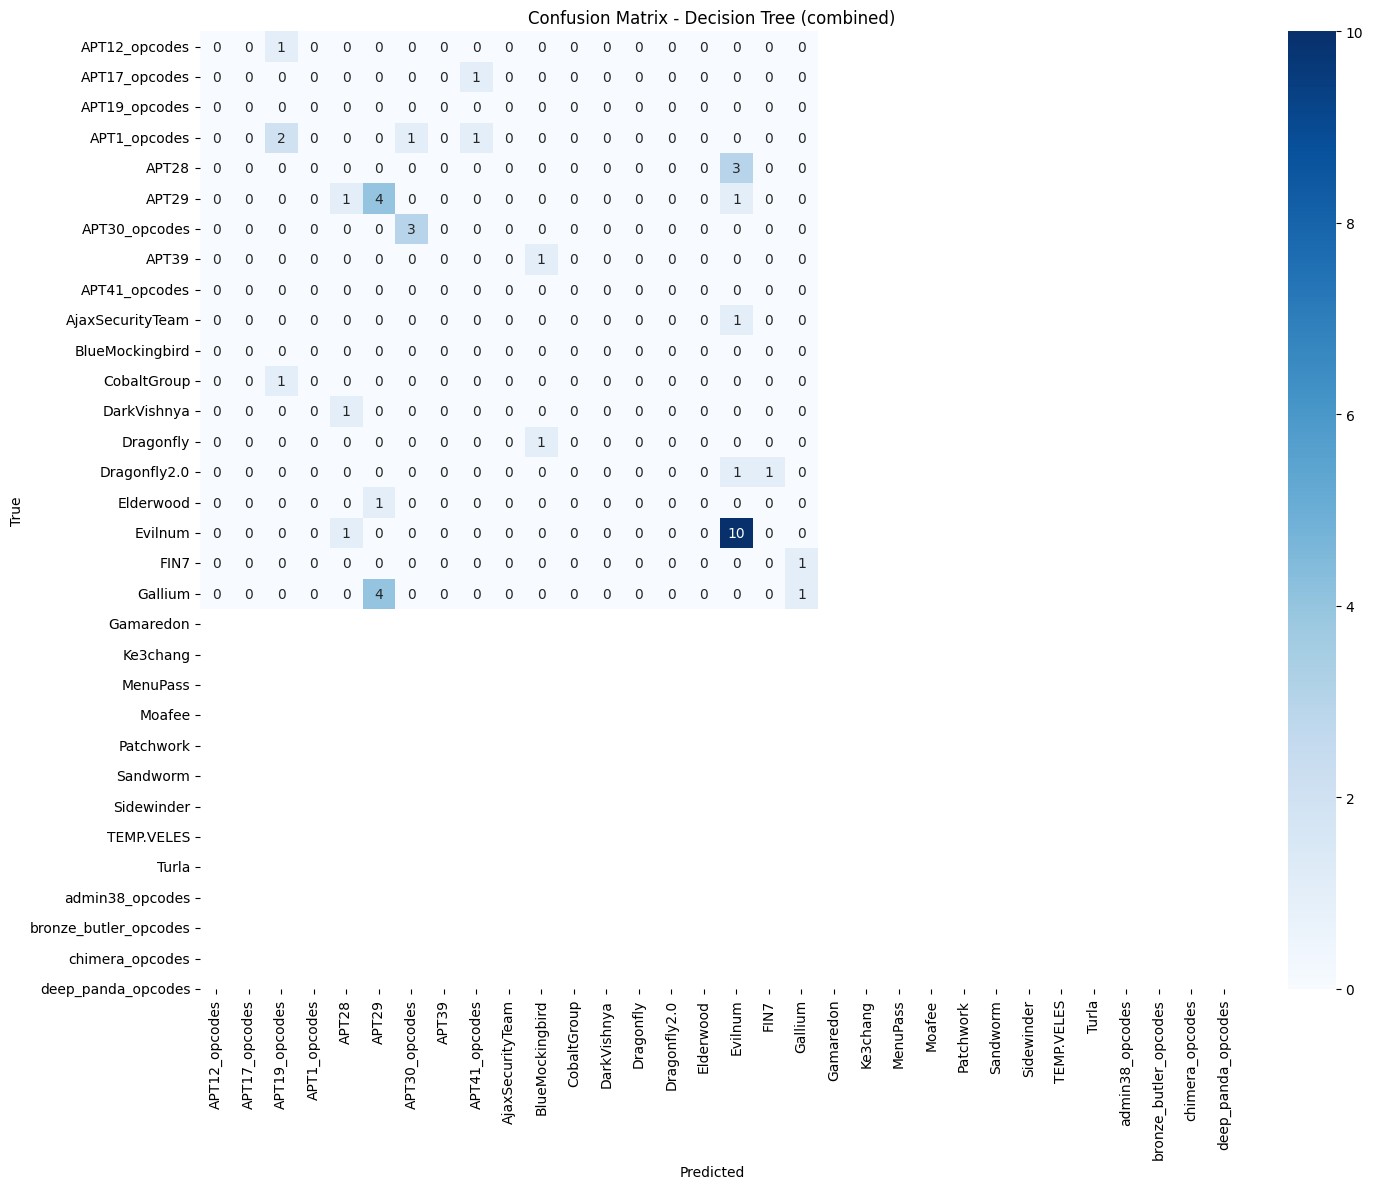

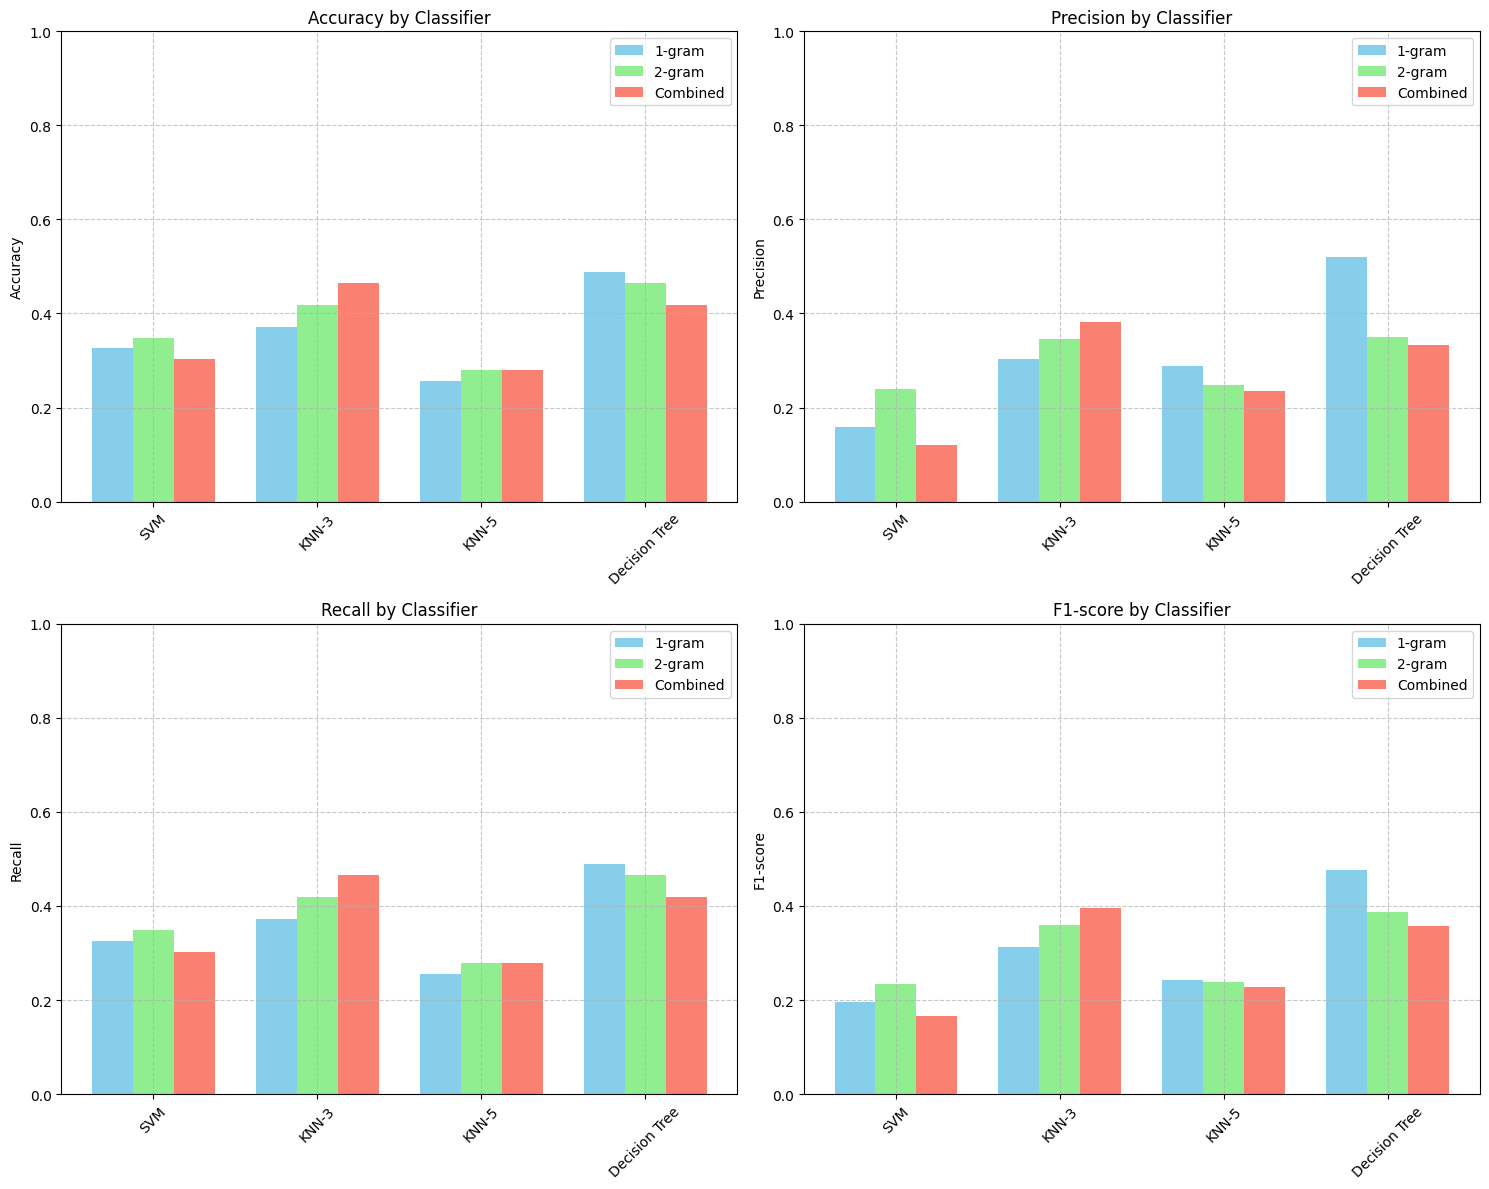

In [6]:
# Create dictionaries to store all metrics
results_1gram = {}
results_2gram = {}
results_combined = {}

# First, create the features dictionary with your data
features = {
    '1gram': (X_1gram, y),
    '2gram': (X_2gram, y),
    'combined': (X, y)  # This should be your combined features
}

def evaluate_classifier(clf, X_train, X_test, y_train, y_test, feature_type, clf_name):
    # Train and predict
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    # Store results in appropriate dictionary
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_true': y_test,
        'y_pred': y_pred
    }
    
    if feature_type == '1gram':
        results_1gram[clf_name] = results
    elif feature_type == '2gram':
        results_2gram[clf_name] = results
    else:
        results_combined[clf_name] = results
    
    # Print classification report
    print(f"{clf_name} Results (before balancing data):")
    print(f"Accuracy: {accuracy:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 80 + "\n")
    
    # Plot confusion matrix
    plt.figure(figsize=(15, 12))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {clf_name} ({feature_type})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
# After all evaluations, plot the metrics comparison
def plot_metrics_comparison():
    classifiers = ['SVM', 'KNN-3', 'KNN-5', 'Decision Tree']
    metrics = {
        '1-gram': {
            'Accuracy': [results_1gram[clf]['accuracy'] for clf in classifiers],
            'Precision': [results_1gram[clf]['precision'] for clf in classifiers],
            'Recall': [results_1gram[clf]['recall'] for clf in classifiers],
            'F1-score': [results_1gram[clf]['f1'] for clf in classifiers]
        },
        '2-gram': {
            'Accuracy': [results_2gram[clf]['accuracy'] for clf in classifiers],
            'Precision': [results_2gram[clf]['precision'] for clf in classifiers],
            'Recall': [results_2gram[clf]['recall'] for clf in classifiers],
            'F1-score': [results_2gram[clf]['f1'] for clf in classifiers]
        },
        'Combined': {
            'Accuracy': [results_combined[clf]['accuracy'] for clf in classifiers],
            'Precision': [results_combined[clf]['precision'] for clf in classifiers],
            'Recall': [results_combined[clf]['recall'] for clf in classifiers],
            'F1-score': [results_combined[clf]['f1'] for clf in classifiers]
        }
    }

    # Create subplots for each metric
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    
    for idx, metric in enumerate(metrics_list):
        ax = axes[idx//2, idx%2]
        
        x = np.arange(len(classifiers))
        width = 0.25
        
        ax.bar(x - width, metrics['1-gram'][metric], width, label='1-gram', color='skyblue')
        ax.bar(x, metrics['2-gram'][metric], width, label='2-gram', color='lightgreen')
        ax.bar(x + width, metrics['Combined'][metric], width, label='Combined', color='salmon')
        
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} by Classifier')
        ax.set_xticks(x)
        ax.set_xticklabels(classifiers, rotation=45)
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_ylim(0, 1.0)

    plt.tight_layout()
    plt.show()

# Now use the features dictionary when evaluating classifiers
for feature_type, (X, y) in features.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    for clf_name, clf in classifiers.items():
        evaluate_classifier(clf, X_train, X_test, y_train, y_test, feature_type, clf_name)

# After all evaluations are complete, plot the comparison
plot_metrics_comparison()

Now we want to balance the dataset so it is not skewed towards the majority classes

In [7]:
def balance_and_evaluate(X, y, classifiers, le):
    # Print original class distribution
    original_dist = Counter(le.inverse_transform(y))
    print("Original class distribution:")
    print(original_dist)
    
    # First use RandomOverSampler to handle classes with single samples
    ros = RandomOverSampler(random_state=42)
    X_ros, y_ros = ros.fit_resample(X, y)
    
    # Then apply SMOTE
    smote = SMOTE(random_state=42, k_neighbors=5)
    X_balanced, y_balanced = smote.fit_resample(X_ros, y_ros)
    
    print("\nBalanced class distribution:")
    print(Counter(le.inverse_transform(y_balanced)))
    
    # Split the balanced dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
    )
    
    # Dictionary to store results
    results = {}
    
    # Evaluate each classifier
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, 
                                    target_names=le.classes_,
                                    zero_division=0)
        
        results[name] = {
            'accuracy': accuracy,
            'report': report
        }
        
        print(f"\n{name} Results (with balanced data):")
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(report)
        print("-" * 80)
    
    return results

# Initialize classifiers with balanced settings
classifiers = {
    'SVM': SVC(kernel='rbf', class_weight='balanced', probability=True),
    'KNN-3': KNeighborsClassifier(n_neighbors=3, weights='distance'),
    'KNN-5': KNeighborsClassifier(n_neighbors=5, weights='distance'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', 
                                          max_depth=10,
                                          min_samples_split=5)
}

# Scale features
scaler = StandardScaler()
X_1gram_scaled = scaler.fit_transform(X_1gram)
X_2gram_scaled = scaler.fit_transform(X_2gram)

# Create combined features by concatenating scaled 1-gram and 2-gram features
X_combined_scaled = np.concatenate([X_1gram_scaled, X_2gram_scaled], axis=1)

# Evaluate with balanced classes
print("\nEvaluating 1-gram features:")
results_1gram = balance_and_evaluate(X_1gram_scaled, y, classifiers, le)

print("\nEvaluating 2-gram features:")
results_2gram = balance_and_evaluate(X_2gram_scaled, y, classifiers, le)

print("\nEvaluating combined features:")
results_combined = balance_and_evaluate(X_combined_scaled, y, classifiers, le)

# Print comparison summary
print("\nAccuracy Comparison Summary (with balanced data):")
print("-" * 80)
print(f"{'Classifier':<15} {'1-gram':>10} {'2-gram':>10} {'Combined':>10}")
print("-" * 80)
for clf_name, _ in classifiers.items():
    print(f"{clf_name:<15} {results_1gram[clf_name]['accuracy']:>10.4f} "
          f"{results_2gram[clf_name]['accuracy']:>10.4f} "
          f"{results_combined[clf_name]['accuracy']:>10.4f}")


Evaluating 1-gram features:
Original class distribution:
Counter({'Moafee': 45, 'APT29': 40, 'Turla': 24, 'APT28': 21, 'APT1_opcodes': 15, 'APT30_opcodes': 15, 'APT19_opcodes': 8, 'Sandworm': 7, 'Ke3chang': 5, 'APT12_opcodes': 5, 'Gallium': 5, 'admin38_opcodes': 2, 'FIN7': 2, 'CobaltGroup': 2, 'MenuPass': 2, 'Evilnum': 1, 'BlueMockingbird': 1, 'Dragonfly': 1, 'Dragonfly2.0': 1, 'DarkVishnya': 1, 'bronze_butler_opcodes': 1, 'Patchwork': 1, 'deep_panda_opcodes': 1, 'AjaxSecurityTeam': 1, 'Elderwood': 1, 'Sidewinder': 1, 'APT17_opcodes': 1, 'Gamaredon': 1, 'chimera_opcodes': 1, 'APT39': 1, 'APT41_opcodes': 1, 'TEMP.VELES': 1})

Balanced class distribution:
Counter({'Evilnum': 45, 'APT19_opcodes': 45, 'BlueMockingbird': 45, 'Dragonfly': 45, 'Dragonfly2.0': 45, 'APT29': 45, 'DarkVishnya': 45, 'Sandworm': 45, 'Turla': 45, 'APT28': 45, 'admin38_opcodes': 45, 'FIN7': 45, 'bronze_butler_opcodes': 45, 'Ke3chang': 45, 'APT1_opcodes': 45, 'Patchwork': 45, 'deep_panda_opcodes': 45, 'APT12_opcodes'

Plot the results post-balancing


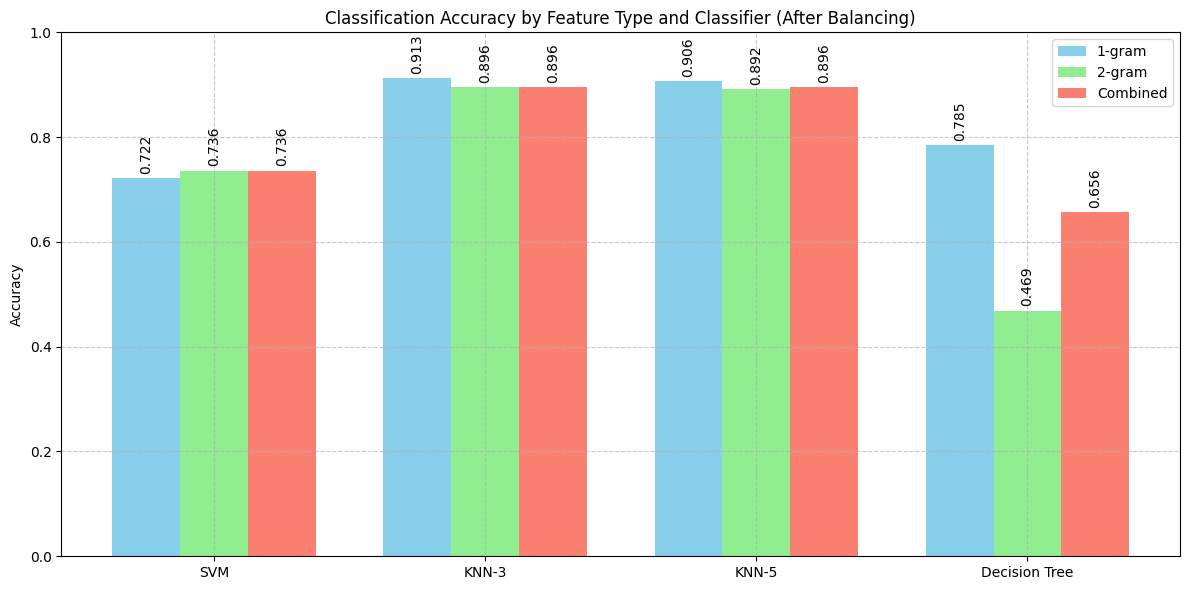

In [8]:
# Data
classifiers = ['SVM', 'KNN-3', 'KNN-5', 'Decision Tree']
accuracies_1gram = [0.7222, 0.9132, 0.9062, 0.7847]
accuracies_2gram = [0.7361, 0.8958, 0.8924, 0.4688]
accuracies_combined = [0.7361, 0.8958, 0.8958, 0.6562]

# Set up bar width and positions
x = np.arange(len(classifiers))
width = 0.25

# Create bars
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, accuracies_1gram, width, label='1-gram', color='skyblue')
rects2 = ax.bar(x, accuracies_2gram, width, label='2-gram', color='lightgreen')
rects3 = ax.bar(x + width, accuracies_combined, width, label='Combined', color='salmon')

# Customize the plot
ax.set_ylabel('Accuracy')
ax.set_title('Classification Accuracy by Feature Type and Classifier (After Balancing)')
ax.set_xticks(x)
ax.set_xticklabels(classifiers)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(rect.get_x() + rect.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom', rotation=90)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Set y-axis limits to start from 0 and end at 1
plt.ylim(0, 1.0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()